# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: Gabriel Rojas
Fecha de entrega: 3 de diciembre

In [ ]:
import os
import sys
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

--2021-12-17 18:10:07--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7403 (7.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.23K  --.-KB/s    in 0s      

2021-12-17 18:10:07 (55.8 MB/s) - ‘utils.py’ saved [7403/7403]



In [ ]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-07i93c_x/cc6204_51b01242764345fc816fcab1c4abfa6e
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-07i93c_x/cc6204_51b01242764345fc816fcab1c4abfa6e
  Created wheel for cc6204: filename=cc6204-0.5.0-py3-none-any.whl size=5800 sha256=528ad6378f07f729d515b9dce983ce71935e6b577eb5236f5c5d9ef979330b33
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijw97ddq/wheels/3c/26/f5/2abeb546c3ff1ab6e69113a3ae69bc0ac3442642727fd0dcc2
Successfully built cc6204
Connection stablished


In [ ]:
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

Connection stablished


In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [ ]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    # Acá inicializa todos los parámetros
    self.C1 = nn.Conv2d(in_channels, ch_3x3_reduce, (1,1), stride=1, padding=0)
    self.bnC1 = nn.BatchNorm2d(ch_3x3_reduce)
    self.D1 = nn.Conv2d(ch_3x3_reduce, ch_3x3, (3,3), stride=1, padding=1)
    self.bnD1 = nn.BatchNorm2d(ch_3x3)

    self.C2 = nn.Conv2d(in_channels, ch_5x5_reduce, (1,1), stride=1, padding=0)
    self.bnC2 = nn.BatchNorm2d(ch_5x5_reduce)
    self.D2 = nn.Conv2d(ch_5x5_reduce, ch_5x5, (5,5), stride=1, padding=2)
    self.bnD2 = nn.BatchNorm2d(ch_5x5)

    self.pool = nn.MaxPool2d((3,3), stride=1, padding=1)
    self.D3 = nn.Conv2d(in_channels, ch_pool_proj, (1,1), stride=1, padding=0)
    self.bnD3 = nn.BatchNorm2d(ch_pool_proj)

    self.D4 = nn.Conv2d(in_channels, ch_1x1, (1,1), stride=1, padding=0)
    self.bnD4 = nn.BatchNorm2d(ch_1x1)


  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    x1 = self.C1(x)
    x1 = F.relu(self.bnC1(x1), inplace=True)
    x1 = self.D1(x1)
    x1 = F.relu(self.bnD1(x1), inplace=True)

    x2 = self.C2(x)
    x2 = F.relu(self.bnC2(x2), inplace=True)
    x2 = self.D2(x2)
    x2 = F.relu(self.bnD2(x2), inplace=True)

    x3 = self.pool(x)
    x3 = self.D3(x3)
    x3 = F.relu(self.bnD3(x3), inplace=True)

    x4 = self.D4(x)
    x4 = F.relu(self.bnD4(x4), inplace=True)

    return torch.cat([x1, x2, x3, x4], dim=1)

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Correct Test!


## 1b) GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True, dropout=0.4, dropout_aux=0.5):
    super(GoogLeNet, self).__init__()

    # Define las capas de convolución y pooling de GoogLeNet
    self.conv1 = nn.Conv2d(3, 64, (7,7), stride=1, padding=3)
    self.pool1 = nn.MaxPool2d((3,3), stride=1, ceil_mode=True)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, (1,1), stride=1, padding=0)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 192, (3,3), stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(192)
    self.pool2 = nn.MaxPool2d((3,3), stride=1, ceil_mode=True)

    self.inception3a = InceptionModule(192, 96, 16, 128, 32, 32, 64)
    self.inception3b = InceptionModule(256, 128, 32, 192, 96, 64, 128)
    self.pool3 = nn.MaxPool2d((3,3), stride=2, ceil_mode=True)

    self.inception4a = InceptionModule(480, 96, 16, 208, 48, 64, 192)
    self.inception4b = InceptionModule(512, 122, 24, 224, 64, 64, 160)
    self.inception4c = InceptionModule(512, 128, 24, 256, 64, 64, 128)
    self.inception4d = InceptionModule(512, 144, 32, 288, 64, 64, 112)
    self.inception4e = InceptionModule(528, 160, 32, 320, 128, 128, 256)
    self.pool4 = nn.MaxPool2d((2,2), stride=2, ceil_mode=True)
    
    self.inception5a = InceptionModule(832, 160, 32, 320, 128, 128, 256)
    self.inception5b = InceptionModule(832, 192, 48, 384, 128, 128, 384)
    
    # Decide si usar la clasificación auxiliar
    self.use_aux_logits = use_aux_logits
    if self.use_aux_logits:
      # Acá lo que necesites inicializar en este caso
      self.aux_conv1 = nn.Conv2d(512, 128, (1,1), stride=1, padding=0)
      self.aux_bn1 = nn.BatchNorm2d(128)
      self.aux_fc1_1 = nn.Linear(2048, 1024)
      self.aux_fc2_1 = nn.Linear(1024, n_classes)
      self.aux_dropout1 = nn.Dropout(p=dropout_aux)

      self.aux_conv2 = nn.Conv2d(528, 128, (1,1), stride=1, padding=0)
      self.aux_bn2 = nn.BatchNorm2d(128)
      self.aux_fc1_2 = nn.Linear(2048, 1024)
      self.aux_fc2_2 = nn.Linear(1024, n_classes)
      self.aux_dropout2 = nn.Dropout(p=dropout_aux)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout(p=dropout)

    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

  def forward(self, x):
    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None

    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = self.pool1(x)
    x = F.relu(self.bn1(x), inplace=True)
    x = self.conv2(x)
    x = F.relu(self.bn2(x), inplace=True)
    x = self.conv3(x)
    x = F.relu(self.bn3(x), inplace=True)
    x = self.pool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.pool3(x)

    x = self.inception4a(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits and self.training:
      aux_logit_1 = F.adaptive_avg_pool2d(x, (4,4))
      aux_logit_1 = self.aux_conv1(aux_logit_1)
      aux_logit_1 = F.relu(self.aux_bn1(aux_logit_1), inplace=True)
      aux_logit_1 = torch.flatten(aux_logit_1, 1)
      aux_logit_1 = F.relu(self.aux_fc1_1(aux_logit_1), inplace=True)
      aux_logit_1 = self.aux_dropout1(aux_logit_1)
      aux_logit_1 = self.aux_fc2_1(aux_logit_1)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_1)

    # Continúa computando las representaciones internas de la red
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    aux_logit_2 = None
    if self.use_aux_logits and self.training:
      aux_logit_2 = F.adaptive_avg_pool2d(x, (4,4))
      aux_logit_2 = self.aux_conv2(aux_logit_2)
      aux_logit_2 = F.relu(self.aux_bn2(aux_logit_2), inplace=True)
      aux_logit_2 = torch.flatten(aux_logit_2, 1)
      aux_logit_2 = F.relu(self.aux_fc1_2(aux_logit_2), inplace=True)
      aux_logit_2 = self.aux_dropout2(aux_logit_2)
      aux_logit_2 = self.aux_fc2_2(aux_logit_2)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_2)

    # Continúa computando las representaciones internas de la red
    x = self.inception4e(x)
    x = self.pool4(x)

    x = self.inception5a(x)
    x = self.inception5b(x)

    x = self.avg_pool(x)
    x = torch.flatten(x, 1)
    hidden = x
    x = self.dropout(x)

    # N x out_size
    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits, 'aux_logits': aux_logits}

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=use_aux_logits)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c) Arquitectura Convolucional: VGG 16-layer (configuracion D)



In [ ]:
# Acá el código para tu primera arquitectura

class VGG16(nn.Module):
  r"""VGG 16-layer (configuration 'D') with batch normalization"""
  def __init__(self, n_classes, dropout=0.5):
    super().__init__()

    # Define las capas de convolución y pooling de tu arquitectura
    self.conv1 = nn.Conv2d(3, 64, (3,3), stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 64, (3,3), stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    
    self.pool1 = nn.MaxPool2d((2,2), stride=1, ceil_mode=True)

    self.conv3 = nn.Conv2d(64, 128, (3,3), stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 128, (3,3), stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(128)

    self.pool2 = nn.MaxPool2d((2,2), stride=1, ceil_mode=True)

    self.conv5 = nn.Conv2d(128, 256, (3,3), stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256, 256, (3,3), stride=1, padding=1)
    self.bn6 = nn.BatchNorm2d(256)
    self.conv7 = nn.Conv2d(256, 256, (3,3), stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)

    self.pool3 = nn.MaxPool2d((2,2), stride=1, ceil_mode=True)

    self.conv8 = nn.Conv2d(256, 512, (3,3), stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(512)
    self.conv9 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
    self.bn9 = nn.BatchNorm2d(512)
    self.conv10 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
    self.bn10 = nn.BatchNorm2d(512)

    self.pool4 = nn.MaxPool2d((2,2), stride=2, ceil_mode=True)

    self.conv11 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
    self.bn11 = nn.BatchNorm2d(512)
    self.conv12 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
    self.bn12 = nn.BatchNorm2d(512)
    self.conv13 = nn.Conv2d(512, 512, (3,3), stride=1, padding=1)
    self.bn13 = nn.BatchNorm2d(512)

    self.pool5 = nn.MaxPool2d((2,2), stride=2)

    self.fc1 = nn.Linear(512 * 7 * 7, 4096)
    self.dropout1 = nn.Dropout(p=dropout)
    self.fc2 = nn.Linear(4096, 4096)
    self.dropout2 = nn.Dropout(p=dropout)

    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(4096, n_classes)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = F.relu(self.bn1(x), inplace=True)
    x = self.conv2(x)
    x = F.relu(self.bn2(x), inplace=True)
    
    x = self.pool1(x)

    x = self.conv3(x)
    x = F.relu(self.bn3(x), inplace=True)
    x = self.conv4(x)
    x = F.relu(self.bn4(x), inplace=True)

    x = self.pool2(x)

    x = self.conv5(x)
    x = F.relu(self.bn5(x), inplace=True)
    x = self.conv6(x)
    x = F.relu(self.bn6(x), inplace=True)
    hidden = torch.flatten(x, 1)
    x = self.conv7(x)
    x = F.relu(self.bn7(x), inplace=True)

    x = self.pool3(x)

    x = self.conv8(x)
    x = F.relu(self.bn8(x), inplace=True)
    x = self.conv9(x)
    x = F.relu(self.bn9(x), inplace=True)
    x = self.conv10(x)
    x = F.relu(self.bn10(x), inplace=True)

    x = self.pool4(x)

    x = self.conv11(x)
    x = F.relu(self.bn11(x), inplace=True)
    x = self.conv12(x)
    x = F.relu(self.bn12(x), inplace=True)
    x = self.conv13(x)
    x = F.relu(self.bn13(x), inplace=True)

    x = self.pool5(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(self.dropout1(x), inplace=True)
    x = self.fc2(x)
    x = F.relu(self.dropout2(x), inplace=True)

    # N x out_size
    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits}

## 1d) Clasificación de Imágenes en CIFAR10

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos 
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch:1(50000/50000), lr:0.1000000, Loss:1.36924, Train Acc:47.6%, Validating..., Val Acc:56.01%, Avg-Time:478.668s.
Epoch:2(50000/50000), lr:0.0500000, Loss:0.84903, Train Acc:69.5%, Validating..., Val Acc:69.18%, Avg-Time:477.751s.
Epoch:3(50000/50000), lr:0.0250000, Loss:0.63776, Train Acc:78.1%, Validating..., Val Acc:78.81%, Avg-Time:477.065s.
Epoch:4(50000/50000), lr:0.0125000, Loss:0.51693, Train Acc:82.8%, Validating..., Val Acc:80.71%, Avg-Time:476.791s.
Epoch:5(50000/50000), lr:0.0062500, Loss:0.43577, Train Acc:86.1%, Validating..., Val Acc:82.31%, Avg-Time:476.673s.
Epoch:6(50000/50000), lr:0.0031250, Loss:0.38507, Train Acc:88.3%, Validating..., Val Acc:83.26%, Avg-Time:476.549s.
Epoch:7(50000/50000), lr:0.0015625, Loss:0.35411, Train Acc:89.6%, Validating..., Val Acc:83.33%, Avg-Time:476.501s.
Epoch:8(50000/50000), lr:0.0007813, Loss:0.34134, Train Acc:90.3%, Validating..., Val Acc:83.25%, Avg-Time:476.478s.
Epoch:9(50000/50000), lr:0.0003906, Loss:0.33182, Train Acc:90.6

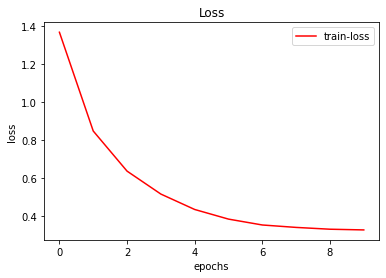

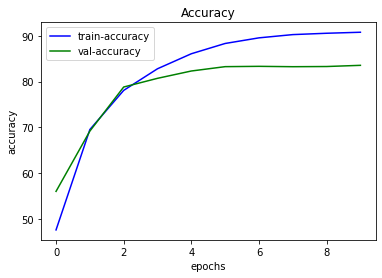

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.1
EPOCHS = 10
REPORTS_EVERY = 1

net = GoogLeNet(10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

In [ ]:
# Test
x, y = list(test_loader)[0]
net.cpu()
net.eval()
y_pred = net(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


Epoch:1(50000/50000), lr:0.0100000, Loss:1.75234, Train Acc:34.6%, Validating..., Val Acc:50.18%, Avg-Time:862.681s.
Epoch:2(50000/50000), lr:0.0100000, Loss:1.26009, Train Acc:54.7%, Validating..., Val Acc:64.19%, Avg-Time:862.710s.
Epoch:3(50000/50000), lr:0.0010000, Loss:0.92252, Train Acc:67.4%, Validating..., Val Acc:70.45%, Avg-Time:862.829s.
Epoch:4(50000/50000), lr:0.0010000, Loss:0.83283, Train Acc:70.4%, Validating..., Val Acc:72.57%, Avg-Time:864.622s.
Epoch:5(50000/50000), lr:0.0001000, Loss:0.76369, Train Acc:73.0%, Validating..., Val Acc:73.41%, Avg-Time:864.401s.
Epoch:6(50000/50000), lr:0.0001000, Loss:0.74728, Train Acc:73.8%, Validating..., Val Acc:73.66%, Avg-Time:863.649s.
Epoch:7(50000/50000), lr:0.0000100, Loss:0.73652, Train Acc:74.2%, Validating..., Val Acc:73.89%, Avg-Time:863.118s.
Epoch:8(50000/50000), lr:0.0000100, Loss:0.73465, Train Acc:74.0%, Validating..., Val Acc:73.78%, Avg-Time:864.292s.
Epoch:9(50000/50000), lr:0.0000010, Loss:0.73364, Train Acc:74.1

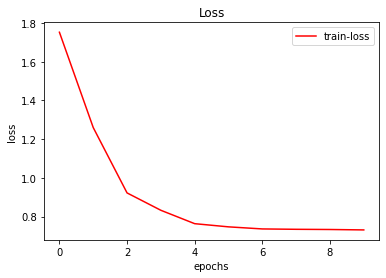

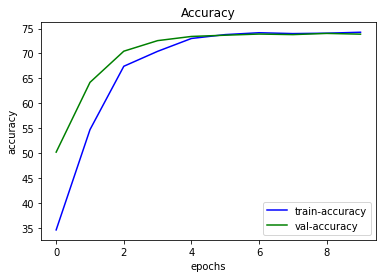

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.01
EPOCHS = 10
REPORTS_EVERY = 1

net = VGG16(10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.5
EPOCHS = 15
REPORTS_EVERY = 1

net = GoogLeNet(100) # tu modelo de CNN (para clasificar en 100 clases)
optimizer = optim.SGD(net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

In [ ]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, cnn_out_size, out_size=128, use_last_bn=True):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.fc1 = nn.Linear(cnn_out_size, 4096)
    self.bn1 = nn.BatchNorm1d(4096)

    self.fc2 = nn.Linear(4096, 1024)
    self.bn2 = nn.BatchNorm1d(1024)

    self.fc_out = nn.Linear(1024, out_size)

    self.use_last_bn = use_last_bn
    if use_last_bn:
        self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    x = self.cnn_model(x)['hidden']

    # Compute las capas de su MLP
    x = self.fc1(x)
    x = F.relu(self.bn1(x))

    x = self.fc2(x)
    x = F.relu(self.bn2(x))

    x = self.fc_out(x)

    if self.use_last_bn:
      x = self.bn(x)

    # En fc_out debe almacenar el encoding en R^d
    return {'logits': x}

In [ ]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128, use_last_bn=True):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.fc1 = nn.Linear(text_embedding_size, 4096)
    self.bn1 = nn.BatchNorm1d(4096)

    self.fc2 = nn.Linear(4096, 1024)
    self.bn2 = nn.BatchNorm1d(1024)

    self.fc_out = nn.Linear(1024, out_size)

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    # Compute las capas de su MLP
    x = self.fc1(x)
    x = F.relu(self.bn1(x))

    x = self.fc2(x)
    x = F.relu(self.bn2(x))

    x = self.fc_out(x)

    if self.use_last_bn:
      x = self.bn(x)

    # En logits debe almacenar el encoding en R^d
    return {'logits': x}

In [ ]:
# Test
OUT_SIZE = 200

cnn_net = GoogLeNet(OUT_SIZE)
i_enc = ImageEncoding(cnn_model=cnn_net, cnn_out_size=1024, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

Correct Test!
Correct Test!


## 2b) Buenas codificaciones y la *Triplet Loss*

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative

  def forward(self, anchor, positive):
    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    dists = torch.cdist(anchor, positive)

    # Obtener distancias "positivas" de la diagonal
    p_dist = torch.diag(dists)
    p_dist = p_dist.unsqueeze(1).expand_as(dists)

    # Ahora genera un tensor con todos los costos
    # siguiendo la formula vista en la orientación de la tarea
    cost = (p_dist - dists + self.margin).clamp(min=0).fill_diagonal_(0)

    # Ahora genera un tensor con todos los costos que se deben agregar
    # dependiendo de la forma de encontrar los negativos
    if self.negative == 'max':
      cost = cost.max(dim=1)[0]
    elif self.negative == 'random':
      # creamos tansor con los pesos para hacer la selección elatoria
      # (una matriz con 1 en todas las posiciones, excepto la diagonal)
      weight = torch.ones_like(cost).fill_diagonal_(0)
      # seleccionamos aleatoriamente un costo negativo por cada anchor
      ids = torch.multinomial(weight, num_samples=1)
      cost = cost.gather(1, ids)
    elif not self.negative == 'all':
      raise ValueError()
    
    # Retorna el promedio de los costos de todos los triples considerados
    return cost[cost>0].mean()

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)

  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

Correct Test!
Correct Test!


## 2c) Probando tu implementación en Flickr8k

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)


*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...
****** Descargando las imágenes...

--2021-12-17 18:10:51--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi  96%[==================> ]   1.01G  6.15MB/s    in 3m 37s  

2021-12-17 18:14:29 (4.75 MB/s) - Connection closed at byte 1080883965. Retrying.

--2021-12-17 18:14:30--  (try: 2)  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1115419746 (1.0G), 34535781 (33M) remaining [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flic

In [ ]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

--2021-12-17 18:17:01--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628212160 (599M) [application/octet-stream]
Saving to: ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’

flickr_cap_encoding 100%[===================>] 599.11M  11.4MB/s    in 98s     

2021-12-17 18:18:40 (6.09 MB/s) - ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’ saved [628212160/628212160]



Epoch:1(6000/6000), lr:0.0001000, Loss:3.52668, Train MRR:0.10 R@10:22.20%, Validating...MRR:0.10 R@10:24.69% Avg-Time:55.177s.
Epoch:2(6000/6000), lr:0.0001000, Loss:2.97748, Train MRR:0.14 R@10:31.73%, Validating...MRR:0.13 R@10:30.20% Avg-Time:54.718s.
Epoch:3(6000/6000), lr:0.0000500, Loss:2.22169, Train MRR:0.20 R@10:43.24%, Validating...MRR:0.15 R@10:35.86% Avg-Time:54.520s.
Epoch:4(6000/6000), lr:0.0000500, Loss:1.80821, Train MRR:0.25 R@10:51.65%, Validating...MRR:0.15 R@10:35.70% Avg-Time:54.434s.
Epoch:5(6000/6000), lr:0.0000250, Loss:1.46548, Train MRR:0.33 R@10:62.68%, Validating...MRR:0.16 R@10:38.03% Avg-Time:54.372s.
Epoch:6(6000/6000), lr:0.0000250, Loss:1.22695, Train MRR:0.41 R@10:71.95%, Validating...MRR:0.16 R@10:39.63% Avg-Time:54.361s.
Epoch:7(6000/6000), lr:0.0000125, Loss:1.01389, Train MRR:0.51 R@10:81.07%, Validating...MRR:0.17 R@10:40.59% Avg-Time:54.332s.
Epoch:8(6000/6000), lr:0.0000125, Loss:0.86406, Train MRR:0.59 R@10:87.11%, Validating...MRR:0.17 R@10:4

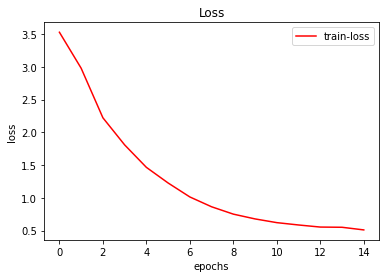

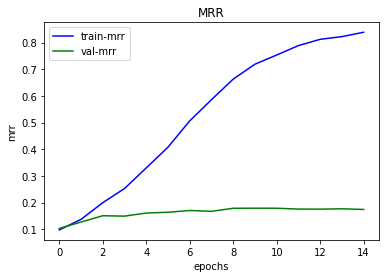

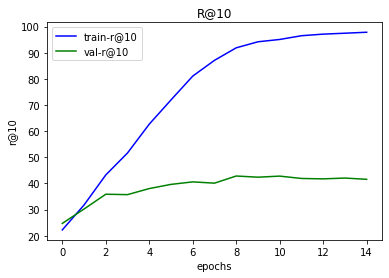

In [ ]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu 
# implementación. 
# En general sólo es necesario que modifiques los lugares con "...", pero 
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 15
REPORTS_EVERY = 1
CNN_OUT_SIZE = 1024
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = "max"

cnn_net = GoogLeNet(OUT_SIZE)
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': img_net.parameters()},  # lista de parametros de img_net
                        {'params': text_net.parameters()}],  # lista de parametros de text_net
                       lr=LR)
criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) # (opcional) optim.lr_scheduler proporciona varios métodos 
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                              train_triplets_loader, 
                                              val_triplets_loader, optimizer, 
                                              criterion, scheduler, EPOCHS, 
                                              REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

Correct Test!


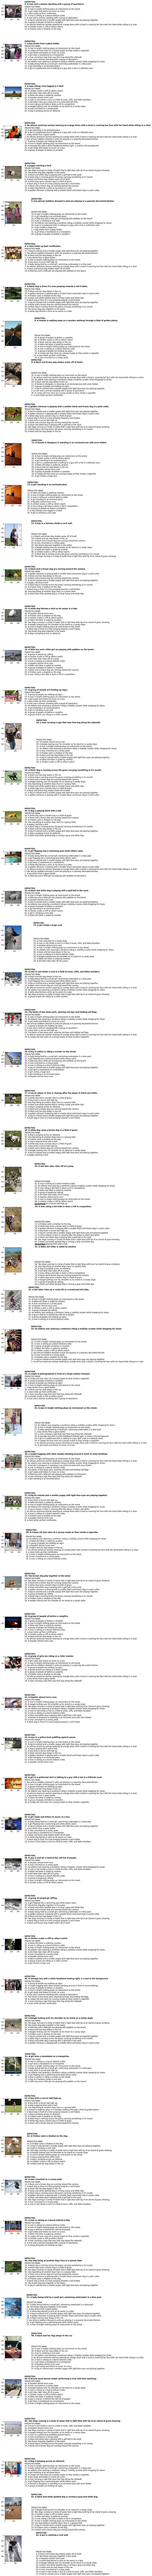

In [ ]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = ...
img_net = ImageEncoding(cnn_model=..., cnn_out_size=CNN_PREV_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},
                        {'params': ...}], 
                       lr=LR)
criterion = TripletLoss(margin=...)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                                     train_triplets_loader, 
                                                     val_triplets_loader, 
                                                     optimizer, criterion, 
                                                     EPOCHS, REPORTS_EVERY, 
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')